## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Pipeline components

### Distortion correction

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def getCameraCalibration():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        plt.imshow(img)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            plt.imshow(img)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

In [2]:
def distortionCorrection(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

### Color space/thresholding
I used a combination of color and gradient thresholds to generate a binary image. The code is shown below.
I've used
- HLS color transform with thresholds for L and S channel
- X Gradient filter & Magnitude filter 

In [3]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def mag_thresh(image, sobel_kernel=9, mag_thresh=(40, 120)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0.7, 1.3)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(gray)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def getThresholdImg(img, showImage=False):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]

    abs_sobel_img = abs_sobel_thresh(img)
    mag_sobel_img = mag_thresh(img)
    dir_sobel_img = dir_threshold(img)

    # Threshold color channel
    s_thresh_min = 190
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    l_thresh_min = 50
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    # S and L channel
    sl_binary = np.zeros_like(s_binary)
    sl_binary[(s_binary == 1) & (l_binary == 1)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((abs_sobel_img, mag_sobel_img, np.zeros_like(mag_sobel_img)))
    color_binary = color_binary * 255
    
    sobel_binary = np.zeros_like(s_binary)
    sobel_binary[(abs_sobel_img == 1) & (mag_sobel_img == 1)] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(sl_binary == 1) | (sobel_binary == 1)] = 1

    if showImage == True:
        # Plotting thresholded images
        f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
        ax1.set_title('Stacked sobel thresholds')
        ax1.imshow(color_binary)

        ax2.set_title('Combined sobel thresholds')
        ax2.imshow(sobel_binary)
        
        ax3.set_title('S & L channel')
        ax3.imshow(sl_binary, cmap='gray')
        
        ax4.set_title('Combined')
        ax4.imshow(combined_binary, cmap='gray')
        
    return combined_binary

### Perspective transform
The code for my perspective transform includes a function called perspectiveTransform(), which appears below The perspectiveTransform() function takes as inputs an image (img), as well as x_loc and y_loc points which descibes the region of interest. I chose the hardcode the x_loc, y_loc and destination points in the following manner:

This resulted in the following source and destination points:

| Source | Destination |
| :------:|:------:|
| 540, 470 | 100, 0 |
| 120, 680 | 100, 720 |
| 1205, 680 | 1180, 720 |
| 750, 470 | 1180, 0 |


In [4]:
def perspectiveTransform(img, x_loc=(540, 120, 1205, 750), y_loc=(470, 680)):
    src = np.float32([[x_loc[0], y_loc[0]],[x_loc[1], y_loc[1]],
                      [x_loc[2], y_loc[1]],[x_loc[3], y_loc[0]]])
    dst = np.float32([[100, 0],[100,720],[1180,720],[1180,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img.shape[0:2][::-1], flags=cv2.INTER_LINEAR)
    return warped, M, Minv

### Lane finding - windowed
This is windowed lane search which is used when there's no previous knowledge of where the lanes are. The basic idea is to find the initial starting point using histogram, and cut the image into rows which it searches within the window centered around the starting point. It updates the starting point for the next row if the number of points exceeds certain threshold.

In [5]:
def windowedSearch(binary_warped, visualize=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    minpoints = 300
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_found = False
    right_found = False
    left_fit = []
    right_fit = []
    # Fit a second order polynomial to each
    if lefty.shape[0] > minpoints:
        left_found = True
        left_fit = np.polyfit(lefty, leftx, 2)
        
    if rightx.shape[0] > minpoints:
        right_found = True
        right_fit = np.polyfit(righty, rightx, 2)
    
    if visualize == True and left_found and right_found:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.figure(figsize=(16,8))
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, binary_warped.shape[1])
        plt.ylim(binary_warped.shape[0], 0)
    
    return left_found, right_found, left_fit, right_fit

### Lane finding - targeted
This is used when we already have an idea of where the lanes are. It creates a window around the fitted line defined by polynomial paramters (left_fit & right_fit) and it re-computes the new polynomial coefficients from the points that lie within in the regiod of interest.

In [6]:
def targetedSearch(binary_warped, left_fit, right_fit, visualize=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    minpoints = 200
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_found = False
    right_found = False
    left_fit = []
    right_fit = []
    # Fit a second order polynomial to each
    if lefty.shape[0] > minpoints:
        left_found = True
        left_fit = np.polyfit(lefty, leftx, 2)
        
    if rightx.shape[0] > minpoints:
        right_found = True
        right_fit = np.polyfit(righty, rightx, 2)
    
    if visualize == True and left_found and right_found:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.figure(figsize=(16,8))
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_found, right_found, left_fit, right_fit

### Radius of curvature and offset
This function calculates the radius of curvature from polynomial coefficients (via differential equation) and it also calculates the offset of camera position in respect to the center of the road. (using bottom X positions of the left and right fit lines and use that to compute the center of the road and find the difference between road center and image center.)

In [7]:
def calculateRadiusAndOffset(binary_warped, left_fit, right_fit, visualize=False):
    ylen = binary_warped.shape[0]
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, ylen-1, num=ylen)# to cover same y-range as image
    y_eval = int(np.max(ploty))
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/binary_warped.shape[0] # meters per pixel in y dimension
    xm_per_pix = 3.7/(right_fitx[y_eval] - left_fitx[y_eval]) # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    
    # offset
    road_center = (right_fitx[y_eval] + left_fitx[y_eval])/2
    offset = (binary_warped.shape[1]/2 - road_center) * xm_per_pix
    
    return (left_curverad + right_curverad)/2, offset

### Draw region and annotate radius and offset
This function uses polynomial coefficients provided to draw the lane line and annotates the image with radius and offset.

In [8]:
def drawRegion(image, warped, left_fit, right_fit, Minv, radius, offset, visualize=False):
    ylen = warped.shape[0]
    ploty = np.linspace(0, ylen-1, num=ylen)# to cover same y-range as image

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    string = 'Radius : {:d}m, Offset : {:s} {:d}cm'.format(int(radius), "R" if offset > 0 else "L", int(abs(offset*100)))
    font = cv2.FONT_HERSHEY_SIMPLEX
    result = cv2.putText(result, string, (10,100), font, 2,(255,255,255),2,cv2.LINE_AA)
    
    if visualize == True:
        plt.figure(figsize=(16,8))
        plt.imshow(result)
    
    return result

## Run pipeline

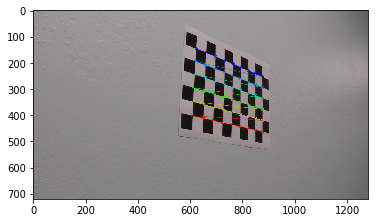

In [9]:
mtx, dist = getCameraCalibration()

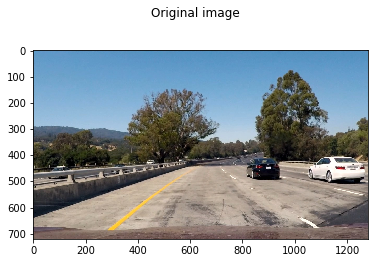

In [83]:
filename = 'test1.jpg'
img = cv2.imread('./test_images/' + filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure().suptitle('Original image')
plt.imshow(img)

### Distortion corrected image

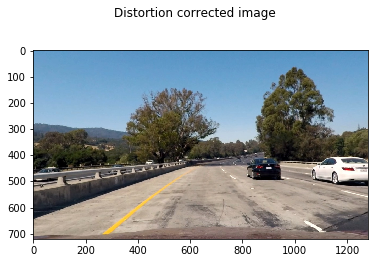

In [84]:
img = distortionCorrection(img,mtx,dist)
plt.figure().suptitle('Distortion corrected image')
plt.imshow(img)

### Threshold image example

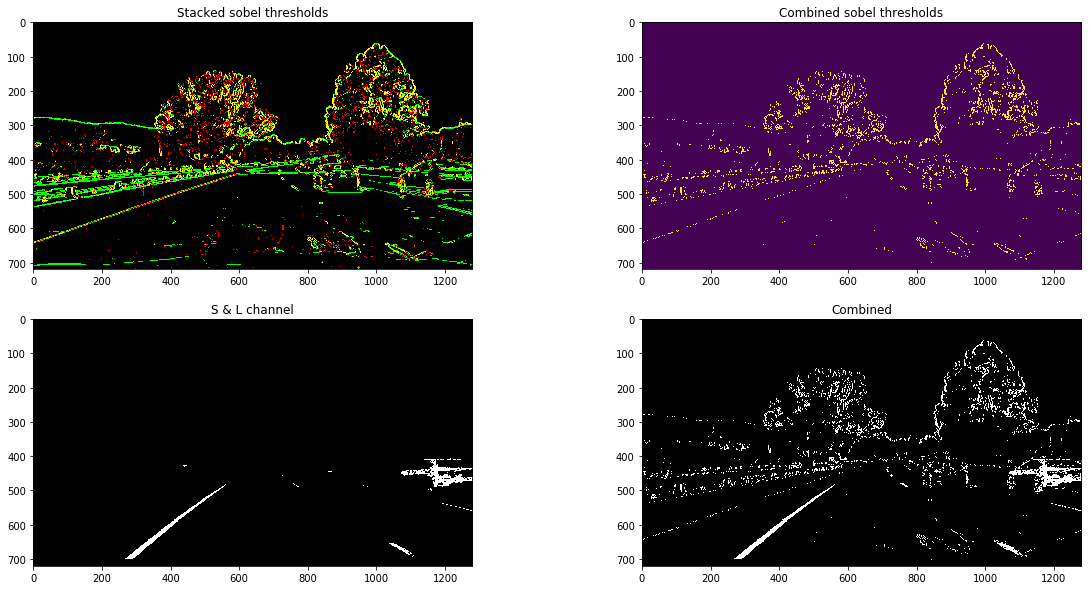

In [85]:
img_b = getThresholdImg(img, True)

### Perspective transformed image

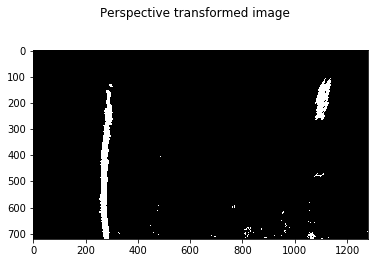

In [86]:
img_p,M,Minv = perspectiveTransform(img_b)
plt.figure().suptitle('Perspective transformed image')
plt.imshow(img_p, cmap='gray')

### Windowed search
Yellow lines are the poly-fit lines.

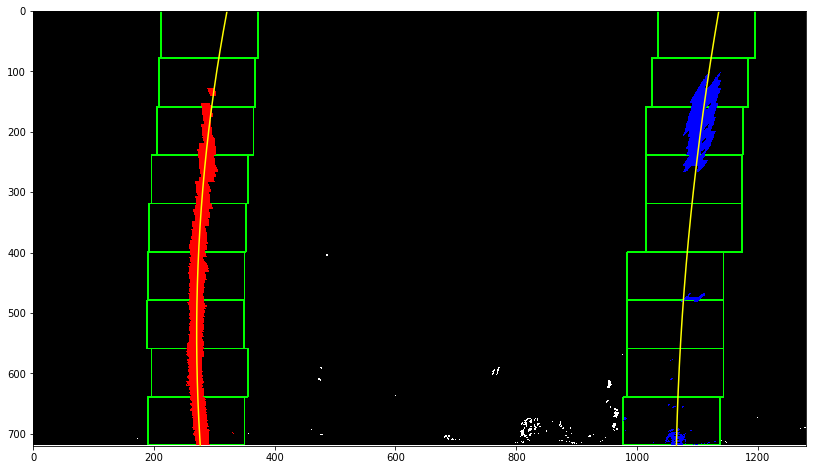

In [87]:
# Windowed search
left_found, right_found, left_fit, right_fit = windowedSearch(img_p, True)

### Targeted search

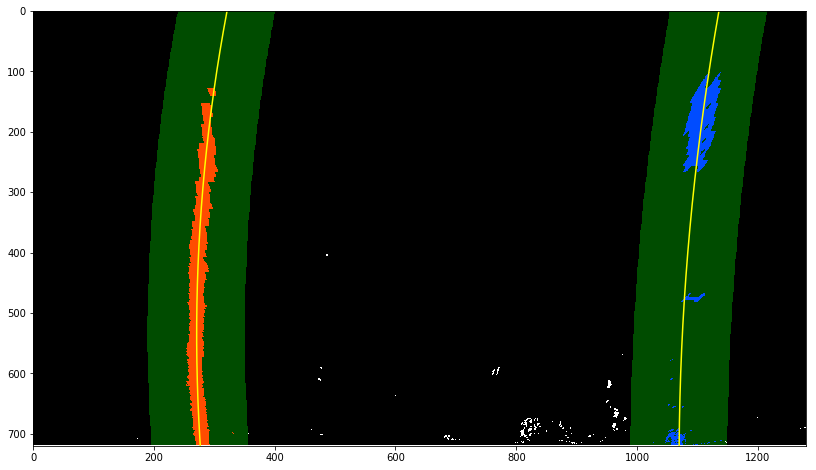

In [88]:
# Targeted search
left_found, right_found, left_fit, right_fit = targetedSearch(img_p, left_fit, right_fit, True)

In [89]:
# Curvature
rad,off = calculateRadiusAndOffset(img_p, left_fit, right_fit)

### Final image

True

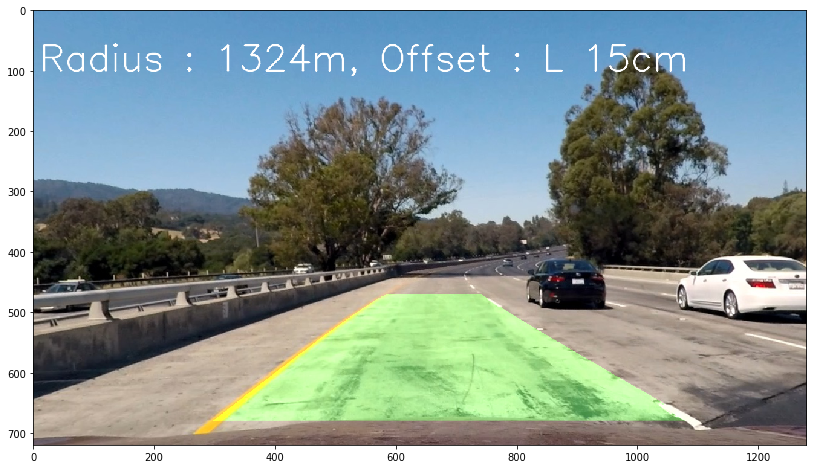

In [90]:
# Draw
img = drawRegion(img, img_p, left_fit, right_fit, Minv, rad, off, True)
cv2.imwrite('./output_images/' + filename, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

## Process video

In [18]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = np.array([])
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def addfit(self, linefit):
        maxlength = 10
        self.current_fit = linefit
        #print(self.recent_xfitted.shape)
        if self.recent_xfitted.shape[0] == 0:
            self.recent_xfitted = np.array([linefit])
        else:
            self.recent_xfitted = np.append(self.recent_xfitted, [linefit], axis=0)
            
        if self.recent_xfitted.shape[0] > maxlength:
            self.recent_xfitted = np.delete(self.recent_xfitted, 0, 0)
        
        self.best_fit = np.mean(self.recent_xfitted, axis=0)


In [19]:
leftLine = Line()
rightLine = Line()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
def process_image(image):
    img_p = distortionCorrection(image,mtx,dist)
    img_p = getThresholdImg(img_p)
    img_p,M,Minv = perspectiveTransform(img_p)
        
    if leftLine.detected and rightLine.detected:
        left_found, right_found, left_fit, right_fit = targetedSearch(img_p, leftLine.current_fit, rightLine.current_fit)
        leftLine.detected = left_found
        rightLine.detected = right_found
        
        if left_found:
            leftLine.addfit(left_fit)
        if right_found:
            rightLine.addfit(right_fit)
        
    if leftLine.detected == False or rightLine.detected == False:
        print("No current fit - window search")
        left_found, right_found, left_fit, right_fit = windowedSearch(img_p)
        leftLine.detected = left_found
        rightLine.detected = right_found
        
        if left_found:
            leftLine.addfit(left_fit)
        if right_found:
            rightLine.addfit(right_fit)
        
    # Do sanity check and update detected
    
    radius = 0
    off = 0
    if leftLine.detected and rightLine.detected:
        radius, off = calculateRadiusAndOffset(img_p, leftLine.best_fit, rightLine.best_fit)
        if np.isnan(radius):
            radius = 10000
            leftLine.detected = False
            rightLine.detected = False 
            
    result = drawRegion(image, img_p, leftLine.best_fit, rightLine.best_fit, Minv, radius, off)            


    return result

In [21]:
video_output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(video_output, audio=False)

No current fit - window search
[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


 47%|████▋     | 589/1261 [01:48<01:48,  6.17it/s]

No current fit - window search
No current fit - window search


 47%|████▋     | 591/1261 [01:48<01:52,  5.95it/s]

No current fit - window search


 49%|████▊     | 613/1261 [01:53<02:20,  4.63it/s]

No current fit - window search
No current fit - window search


 49%|████▊     | 614/1261 [01:53<02:11,  4.94it/s]

No current fit - window search
No current fit - window search


 49%|████▉     | 617/1261 [01:54<01:59,  5.39it/s]

No current fit - window search
No current fit - window search


 49%|████▉     | 619/1261 [01:54<01:55,  5.58it/s]

No current fit - window search
No current fit - window search


 49%|████▉     | 621/1261 [01:54<01:53,  5.65it/s]

No current fit - window search
No current fit - window search


 49%|████▉     | 623/1261 [01:55<01:50,  5.75it/s]

No current fit - window search
No current fit - window search


 49%|████▉     | 624/1261 [01:55<01:49,  5.80it/s]

No current fit - window search
No current fit - window search


 50%|████▉     | 626/1261 [01:55<01:59,  5.30it/s]

No current fit - window search
No current fit - window search


 50%|████▉     | 628/1261 [01:56<01:57,  5.40it/s]

No current fit - window search
No current fit - window search


 51%|█████     | 637/1261 [01:57<01:47,  5.79it/s]

No current fit - window search
No current fit - window search


100%|█████████▉| 1260/1261 [03:51<00:00,  5.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 4min 5s, sys: 1min 3s, total: 5min 8s
Wall time: 3min 51s


## Discussion
#### Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

The noise in the road (e.g. tire marks) or shadows proved to be a challenge to distinguish from lane lines. I've used L channel to effectively mask out shadows and marks but this can fail as the ambient brightness level changes (e.g. night, cloudy weather). A variable threshold based on the image characteristic might be beneficial to address this. 
